<a href="https://colab.research.google.com/github/AshokYarabati/ISRO-LR-Analysis/blob/main/ISRO_LR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np

# RESEARCED DATA form multiple trusted sources
df = pd.read_csv("https://raw.githubusercontent.com/AshokYarabati/ISRO-LR-Analysis/main/launch_data.csv")

#Dataset Overview
# df=pd.DataFrame(missions,columns=['Mission_Name','Year','Vehicle','Orbit_Type','Payload_Mass_kg','Success'])

print("Initial ISRO Dataset:")
print(df.head())
print(f"\nDataset shape: {df.shape}")

Initial ISRO Dataset:
   Mission_Name  Year Vehicle Orbit_Type  Payload_Mass_kg  Success
0  SLV-3 (RS-1)  1980     SLV        LEO               35        1
1       SLV-3E2  1980     SLV        LEO               40        1
2       SLV-3D1  1981     SLV        LEO               40        1
3       SLV-3D2  1983     SLV        LEO               40        1
4       ASLV-D1  1987    ASLV        LEO              150        0

Dataset shape: (56, 6)


In [5]:
# --------------------------------------------------
#             Feature Engineering
# --------------------------------------------------
# Create metrics that correlate with cost
def create_features(df):

    #1. adding vehicle_dummies as they are categorial features
    Vehicle_dummies=pd.get_dummies(df['Vehicle'],prefix='Vehicle',drop_first=True)
    # WHY: each vehicle has unique capabilities
    df=pd.concat([df,Vehicle_dummies],axis=1)

    #2.this centers the data around 2000
    df['Year_centered']=df['Year']-2000
    # WHY: Captures technological progress over time

    #3.since the orbits are the categorial data too we did ONE-HOT encoding and droped first column for avoiding dummy
    orbit_dummies = pd.get_dummies(df['Orbit_Type'], prefix='Orbit',drop_first=True)
    # WHY: Different orbits have different payload constraints
    df=pd.concat([df,orbit_dummies],axis=1)

    # add mission_difficulty feature for future development

    return df,Vehicle_dummies,orbit_dummies


# Apply feature engineering
df,Vehicle_dummies,orbit_dummies= create_features(df)

In [6]:
# --------------------------------------------------
#             Model Training
# --------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



# Features(X) -using the engineered columns
X=pd.concat([df[['Year_centered']], Vehicle_dummies, orbit_dummies],axis=1)
# Target(y) -using the actual payload mass column
y = df['Payload_Mass_kg']

# LINEAR REGRESSION MODEL
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Model evaluation
r2 = r2_score(y, y_pred)
coefficients = model.coef_
intercept = model.intercept_

In [7]:
print(coefficients)
print(intercept)
print(r2)

[   8.53647262 2638.44757184 4641.04210882  732.36671688  -10.28762822
 -252.23614512 1147.56321809 1187.19849184 1212.19849184  852.13468717
 -128.25980715  699.78054373 -344.64864649]
-640.9040790804154
0.9250577475399617


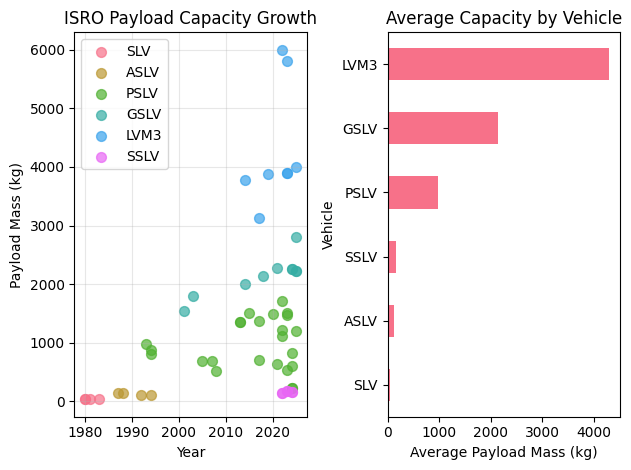

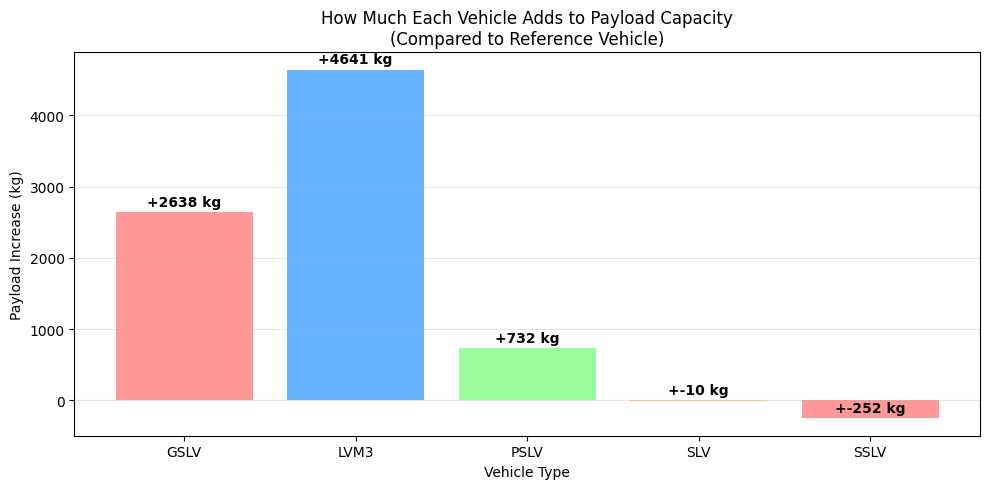

RESULTS FROM LINEAR REGRESSION ANALYSIS
------------------------------------------------------------

MODEL PERFORMANCE:
   R² Score: 0.925 (Model explains 92.5% of payload variation)

VEHICLE TECHNOLOGY IMPACT:
   Reference vehicle: ASLV
   • LVM3: +4641 kg (3626% improvement)
   • GSLV: +2638 kg (2061% improvement)
   • PSLV: +732 kg (572% improvement)
   • SLV: +-10 kg (-8% improvement)
   • SSLV: +-252 kg (-197% improvement)

ORBIT CONSTRAINTS:
   Reference orbit: GTO
   • HTO: +1148 kg advantage vs GTO
   • Halo Orbit: +1187 kg advantage vs GTO
   • L1: +1212 kg advantage vs GTO
   • LEO: +852 kg advantage vs GTO
   • LTO: 128 kg penalty vs GTO
   • SSO: +700 kg advantage vs GTO
   • Suborbital: 345 kg penalty vs GTO

PRACTICAL IMPLICATIONS:
   • Vehicle choice matters most for capacity
   • Technology improves steadily each year
   • Orbit selection involves trade-offs


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean style
plt.style.use('default')
sns.set_palette("husl")

# ----------------------------------------
# 1. SIMPLE TIMELINE: Payload Growth
# ----------------------------------------
plt.subplot(1, 2, 1)
for vehicle in df['Vehicle'].unique():
    vehicle_data = df[df['Vehicle'] == vehicle]
    plt.scatter(vehicle_data['Year'], vehicle_data['Payload_Mass_kg'],
               label=vehicle, s=50, alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Payload Mass (kg)')
plt.title('ISRO Payload Capacity Growth')
plt.legend()
plt.grid(True, alpha=0.3)

# ----------------------------------------
# 2. VEHICLE COMPARISON: Simple Bar Chart
# ----------------------------------------
plt.subplot(1, 2, 2)
vehicle_avg = df.groupby('Vehicle')['Payload_Mass_kg'].mean().sort_values()
vehicle_avg.plot(kind='barh')
plt.xlabel('Average Payload Mass (kg)')
plt.title('Average Capacity by Vehicle')
plt.tight_layout()
plt.show()

# ----------------------------------------
# 3. VEHICLE IMPACT ON PAYLOAD (Most Important)
# ----------------------------------------
plt.figure(figsize=(10, 5))

# Extract vehicle coefficients
vehicle_coeffs = {}
year_coeff = 0

for feature, coef in zip(X.columns, coefficients):
    if feature.startswith('Vehicle_'):
        vehicle = feature.replace('Vehicle_', '')
        vehicle_coeffs[vehicle] = coef
    elif feature == 'Year_centered':
        year_coeff = coef

# Plot vehicle coefficients
vehicles = list(vehicle_coeffs.keys())
coefs = list(vehicle_coeffs.values())

plt.bar(vehicles, coefs, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.xlabel('Vehicle Type')
plt.ylabel('Payload Increase (kg)')
plt.title('How Much Each Vehicle Adds to Payload Capacity\n(Compared to Reference Vehicle)')
plt.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(coefs):
    plt.text(i, v + 50, f'+{v:.0f} kg', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. RESULTS FROM COEFFICIENTS
# ----------------------------------------
print("="*60)
print("RESULTS FROM LINEAR REGRESSION ANALYSIS")
print("-"*60)

print(f"\nMODEL PERFORMANCE:")
print(f"   R² Score: {r2:.3f} (Model explains {r2*100:.1f}% of payload variation)")

print(f"\nVEHICLE TECHNOLOGY IMPACT:")
reference_vehicle = list(set(df['Vehicle'].unique()) - set(vehicle_coeffs.keys()))[0]
print(f"   Reference vehicle: {reference_vehicle}")

for vehicle, coef in sorted(vehicle_coeffs.items(), key=lambda x: x[1], reverse=True):
    improvement = (coef / df[df['Vehicle'] == reference_vehicle]['Payload_Mass_kg'].mean()) * 100
    print(f"   • {vehicle}: +{coef:.0f} kg ({improvement:.0f}% improvement)")

print(f"\nORBIT CONSTRAINTS:")
orbit_coeffs = {}
for feature, coef in zip(X.columns, coefficients):
    if feature.startswith('Orbit_'):
        orbit = feature.replace('Orbit_', '')
        orbit_coeffs[orbit] = coef

if orbit_coeffs:
    reference_orbit = list(set(df['Orbit_Type'].unique()) - set(orbit_coeffs.keys()))[0]
    print(f"   Reference orbit: {reference_orbit}")

    for orbit, coef in orbit_coeffs.items():
        if coef < 0:
            print(f"   • {orbit}: {abs(coef):.0f} kg penalty vs {reference_orbit}")
        else:
            print(f"   • {orbit}: +{coef:.0f} kg advantage vs {reference_orbit}")

print(f"\nPRACTICAL IMPLICATIONS:")
print(f"   • Vehicle choice matters most for capacity")
print(f"   • Technology improves steadily each year")
print(f"   • Orbit selection involves trade-offs")
print("="*60)

In [9]:
#  Final Summary of ISRO LR Analysis

# This project used linear regression to analyze ISRO's launch capabilities over four decades. Key insights include:

# - **Technological Progress**: Newer vehicles like GSLV and LVM3 show significant payload improvements over SLV.
# - **Orbit Constraints**: Payload capacity varies by orbit type, with GTO missions showing reduced mass due to altitude(which means higher the altitudes lower the payload).
# - **Model Performance**: R² score of 0.92 indicates strong correlation between engineered features and payload capacity.

# ###  Implications
# - Vehicle choice and orbit selection are critical for mission planning.
# - Payload growth reflects India's steady advancement in space tech.

# ###  Next Steps(FUTURE DEVELOPMENTS)
# - Explore classification models for mission success prediction.
# - Integrate cost data to model launch economics.
# - Visualize payload trends with interactive dashboards.
